## Project part 2: Mobile Games A/B Test

This dataset includes A/B test results of Cookie Cats game to  
examine what happens when the first gate in the game was moved from level  
30 to level 40. When a player installed the game, he or she was randomly  
assigned to eighter gate_30 or gate_40.  
**Goal**: The goal of this A/B test is to analyse in which level(30 or 40) player  
should encounter gate to keep players longer in the game.  
**Target metric**:-----------------------------------------------------------------  
Considering retention for 7 days, is there a difference in players positive count  
proportion between gate 30 and gate 40?  
**Population**: Players who came back and play after 7 days after installing  
**Parameter of interest**: Proportion of positive count (True) players  
**Individual populations**: Gate 30 and Gate 40

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as st
from functions_sandbox import cleaner

location = r"D:\IT_projects\Turing_Colledge\Modul2\Sprint2\project\cookie_cats\cookie_cats.csv"
cookie_cats = pd.read_csv(location)

In [98]:
cookie_cats.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [99]:
cookie_cats.tail(5)

,userid,version,sum_gamerounds,retention_1,retention_7
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


In [100]:
cookie_cats = cleaner(cookie_cats, info=True)

All columns empty spaces have been stripped.
All columns names have been converted to lowercase.

Is there any duplicates?: False
Is there any NaN numbers?: False
Is there any empty cells?: False
Dataframe shape: (90189, 5)


In [101]:
cookie_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [102]:
cookie_cats[["retention_1", "retention_7"]] = cookie_cats[
    ["retention_1", "retention_7"]
].astype(int)

## Exploratory Data Analysis

In [103]:
cookie_cats[["userid", "sum_gamerounds"]].describe().T

,count,mean,std,min,25%,50%,75%,max
userid,90189.0,4.998412e+06,2.883286e+06,116.0,2512230.0,4995815.0,7496452.0,9999861.0
sum_gamerounds,90189.0,5.187246e+01,1.950509e+02,0.0,5.0,16.0,51.0,49854.0


In [104]:
proportions = (
    cookie_cats.groupby("version")
    .agg(
        {
            "userid": "count",
            "retention_1": lambda x: (x == 1).sum(),
            "retention_7": lambda x: (x == 1).sum(),
        }
    )
    .reset_index()
)
proportions["ret1_prop"] = (proportions["retention_1"] / proportions["userid"]) * 100
proportions["ret7_prop"] = (proportions["retention_7"] / proportions["userid"]) * 100
proportions

,version,userid,retention_1,retention_7,ret1_prop,ret7_prop
0,gate_30,44700,20034,8502,44.818792,19.020134
1,gate_40,45489,20119,8279,44.228275,18.200004


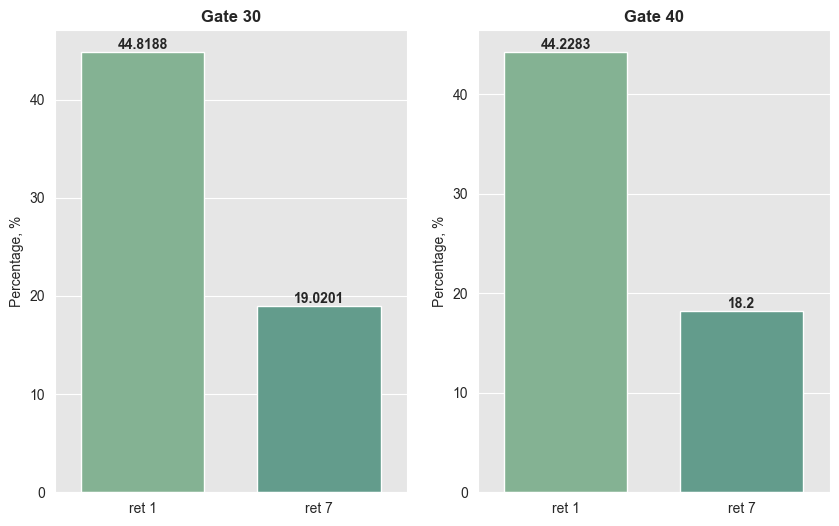

In [105]:
g30x = ["ret 1", "ret 7"]
g30y = [proportions.loc[0, "ret1_prop"], proportions.loc[0, "ret7_prop"]]
g40x = ["ret 1", "ret 7"]
g40y = [proportions.loc[1, "ret1_prop"], proportions.loc[1, "ret7_prop"]]

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.set_palette("crest")

sns.barplot(x=g30x, y=g30y, hue=g30x, width=0.7, ax=ax[0])
ax[0].set_ylabel("Percentage, %")
ax[0].set_title("Gate 30", fontweight="bold", ha="center")
for container in ax[0].containers:
    ax[0].bar_label(container, fontweight="bold")

sns.barplot(x=g40x, y=g40y, hue=g40x, width=0.7, ax=ax[1])
ax[1].set_ylabel("Percentage, %")
ax[1].set_title("Gate 40", fontweight="bold", ha="center")
for container in ax[1].containers:
    ax[1].bar_label(container, fontweight="bold")

plt.show()

#### Hypotheses

**Null**(H0:p1=p2): There is no significant difference in 7 days retention  
success rate between Gate 30 and Gate 40.  
**Alternative**(Ha:p1!=p2): There is significant difference in 7 days retention  
success rate between Gate 30 and Gate 40.

In [107]:
success = ([8502, 8279])
nobs = ([44700, 45489])
ztest = proportions_ztest(success, nobs)
p1 = success[0] / nobs[0]
p2 = success[1] / nobs[1]
diff = p1 - p2
se_diff = np.sqrt((p1 * (1 - p1) / nobs[0]) + (p2 * (1 - p2) / nobs[1]))
diff_ci = st.norm.interval(0.95, loc=diff, scale=se_diff)

print(f"z-statistic, p-value: {ztest}")
print(f"CI for the difference in proportions: {diff_ci}")

z-statistic, p-value: (3.164358912748191, 0.001554249975614329)
CI for the difference in proportions: (0.0031210442115262808, 0.013281552418885545)


Because p-value is < than 0.05 and the CI for the difference in proportions does  
not contain zero, it is enought evidence to reject H0 hypothesis, which means  
that there is significant difference between gate 30 and gate 40 versions of  
seven days retention.  
Based on estimated difference in two independent samples proportions, we can  
say that gate 30 version of 7 days retention has significantly higher success  
rate.

#### Bootstrap statistics

In [108]:
def bootstrap(df, contr_test_param, metric, iters=500):
    bootstr = []
    for i in range(iters):
        bootmean = df.sample(frac=1, replace=True).groupby(contr_test_param)[metric].mean()
        bootstr.append(bootmean)
    bootstr = pd.DataFrame(bootstr)
    return bootstr

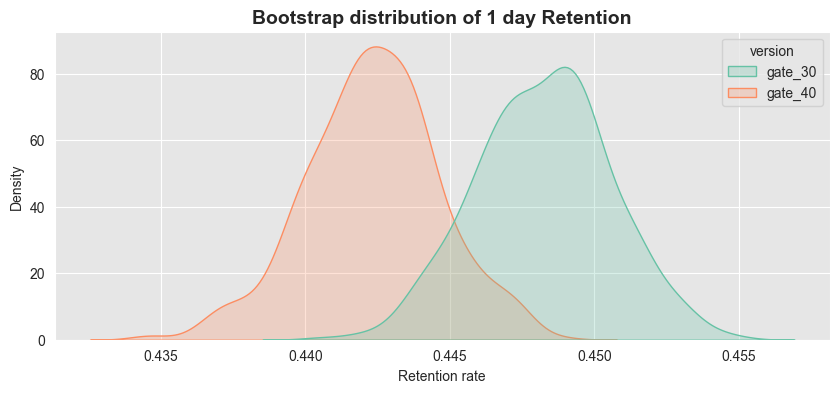

In [109]:
ret_1_boot = bootstrap(df=cookie_cats, contr_test_param="version", metric="retention_1")
plt.figure(figsize=(10, 4))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.kdeplot(data=ret_1_boot, fill=True, palette="Set2")
plt.xlabel("Retention rate")
plt.title(
    "Bootstrap distribution of 1 day Retention",
    fontsize=14,
    fontweight="bold",
    ha="center",
)

plt.show()

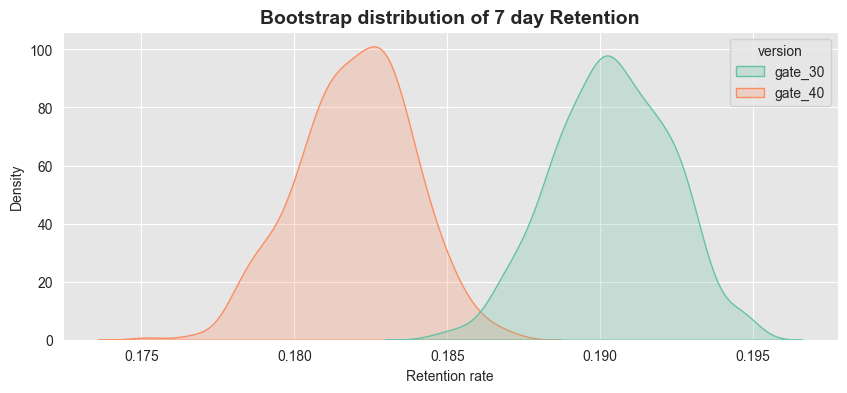

In [110]:
ret_7_boot = bootstrap(df=cookie_cats, contr_test_param="version", metric="retention_7")
plt.figure(figsize=(10, 4))
sns.set_style("darkgrid", {"axes.facecolor":".9"})
sns.kdeplot(data=ret_7_boot, fill=True, palette="Set2")
plt.xlabel("Retention rate")
plt.title(
    "Bootstrap distribution of 7 day Retention",
    fontsize=14,
    fontweight="bold",
    ha="center"
)

plt.show()

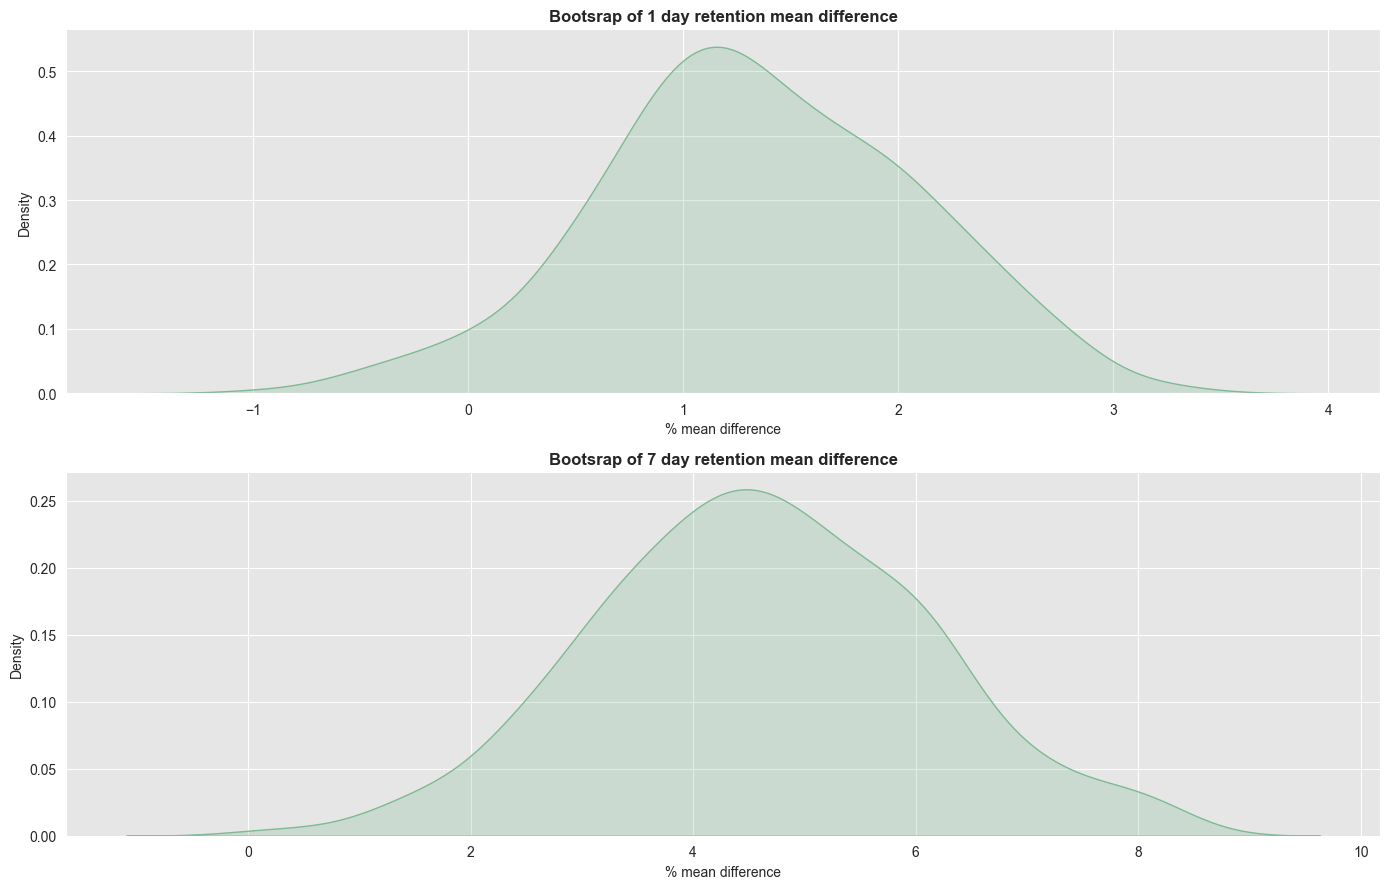

In [111]:
ret_1_boot["diff"] = (ret_1_boot["gate_30"] - ret_1_boot["gate_40"]) / ret_1_boot["gate_40"] * 100
ret_7_boot["diff"] = (ret_7_boot["gate_30"] - ret_7_boot["gate_40"]) / ret_7_boot["gate_40"] * 100

fig, ax = plt.subplots(2, 1, figsize=(14, 9))
sns.set_style("darkgrid", {"axes.facecolor":".9"})
sns.kdeplot(data=ret_1_boot["diff"], fill=True, ax=ax[0])
ax[0].set_xlabel("% mean difference")
ax[0].set_title("Bootsrap of 1 day retention mean difference", fontweight="bold")

sns.kdeplot(data=ret_7_boot["diff"], fill=True, ax=ax[1])
ax[1].set_xlabel("% mean difference")
ax[1].set_title("Bootsrap of 7 day retention mean difference", fontweight="bold")
plt.tight_layout()

plt.show()

**Decision**:  
Bootstrap results tells us that there is a strong evidence  
that 7 day retention is higher when version of gate 30  
is choosed than gate 40.  
If we want to keep retention higher, we would not need  
to move gate 30 to 40. Gate 30 is a better choice.

*Summary of the project could be found at ReadMe.md file*